<a href="https://colab.research.google.com/github/dbamman/nlp21/blob/master/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [2]:
!python -m nltk.downloader punkt

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Let's download the data we'll use for training and development, and also the data we'll use to make predictions for.

In [3]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp21/main/HW2/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp21/main/HW2/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp21/main/HW2/test.txt

--2021-02-01 03:35:37--  https://raw.githubusercontent.com/dbamman/nlp21/main/HW2/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.26M  --.-KB/s    in 0.09s   

2021-02-01 03:35:38 (14.7 MB/s) - ‘train.txt’ saved [1322055/1322055]

--2021-02-01 03:35:38--  https://raw.githubusercontent.com/dbamman/nlp21/main/HW2/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt’

dev.txt       

In [4]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

In [5]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

*First*, let's define a classifier based on a really simple dictionary-based feature: if the abstract contains the words "love" or "like", the CONTAINS_POSITIVE_WORD feature will fire, and if it contains either "hate" or "dislike", the CONTAINS_NEGATIVE_WORD will fire.  Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words.

In [6]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data.  Note the `L2_regularization_strength` specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and the `min_feature_count` specifies how many data points need to contain a feature for it to be allowable as a feature in the model.  Both are ways to prevent the model from overfitting and achieve higher performance.

In [7]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


First, is this accuracy score any good?  Let's calculate the accuracy of a majority class predictor to provide some context.  Again, this determines the most represented (majority) class in the training data, and then predicts every test point to be this class.

In [8]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


# Your assignment

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm three additional distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data. 

Describe your features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words| Having a binary value for each word showed up in the review can us figure out the correlation between the word and the label pos/neg.|0.771
|Feature 1| Counting the number of times that a typical sentiment phrase of two-grams correlated with label pos or label neg can help us inform the model to accurately predict the label. Also, words starting with un- and over- are usually linked with negative sentiments, so we include those words as well.|0.599
|Feature 2| Counting the number of positive words and negative words shown in the AFINN dictionary can help the model predict positive or negative label.|0.703
|Feature 3| Calculating the sum of positive sentiment scores, negative sentiment scores, and overall sentiment scores using the AFINN dictionary can help the model understand the direction and magnitude of the label for positive or negative.|0.713

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment.


In [9]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        
        if word not in feats:
          feats[word] = 1

    return feats

In [25]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 21224, Train accuracy: 1.000, Dev accuracy: 0.771


In [14]:
'''feature 1: count of typical sentiment phrases or words'''
def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        if re.search('un.+', word.lower()) or re.search('over.+', word.lower()):
          if word not in feats:
            feats[word] = 1
          else:
            feats[word] += 1

    for i in range(1, len(words)):
        twoGram = str(words[i-1]).lower() + ' ' + str(words[i])

        if twoGram in ['i like', 'i love', 'how amazing']:
          feats['contains_pos'] = 1
          if twoGram not in feats:
            feats[twoGram] = 1
          else:
            feats[twoGram] += 1
        if twoGram in ["i don't", "not like", "don't like", 'i hate', 'i dislike','fast forward',
                       'not funny', 'not cool', 'not good', 'better not', 'could have']:
          feats['contains_neg'] = 1
          if twoGram not in feats:
            feats[twoGram] = 1
          else:
            feats[twoGram] += 1
        
    return feats


In [15]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 940, Train accuracy: 0.816, Dev accuracy: 0.599


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# download a dictionary of AFINN, 2477 words. Source: http://www2.imm.dtu.dk/pubdb/pubs/6010-full.html
# with key as word and value as scale from very negative -5 to very positive +5
afinnlst = [line.strip().split('\t') for line in open('/content/drive/MyDrive/Info 259 NLP/AFINN-111.txt')]
afinn = dict()
for k, v in afinnlst:
  afinn[k] = int(v)
len(afinn)

2477

In [18]:
'''feature 2: count of positive or negative words found in AFINN dictionary'''
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {'pos_in_AFINN': 0, 'neg_in_AFINN': 0}
    words = nltk.word_tokenize(text)

    for word in words:
      word = word.lower()
      if word in afinn:
        sentScore = afinn[word]
        if sentScore > 0:
          feats['pos_in_AFINN'] += 1
        elif sentScore < 0:
          feats['neg_in_AFINN'] += 1

    return feats

In [19]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 2, Train accuracy: 0.713, Dev accuracy: 0.703


In [20]:
'''feature 3: sum of overall sentiment scores, sum of positive scores, and sum of negative scores based on AFINN dictionary'''
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    words = nltk.word_tokenize(text)

    total, pos, neg = 0, 0, 0
    for word in words:
      word = word.lower()
      if word in afinn:
        total += afinn[word]
        if afinn[word] > 0:
          pos += afinn[word]
        elif afinn[word] < 0:
          neg += afinn[word]
    
    feats = {'sumScore': total, 'posScore': pos, 'negScore': neg}
            
    return feats

In [21]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 3, Train accuracy: 0.724, Dev accuracy: 0.713


Next, let's combine any or all the features you have developed into one big model and make predictions on the test data.

In [23]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [bag_of_words, feature1, feature2, feature3]:
    all_feats.update(feature(text))
  return all_feats

In [41]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=0.2, min_feature_count=50)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 439, Train accuracy: 0.926, Dev accuracy: 0.761


 ## Deliverable 2

This code will generate a file named `combiner_function_predictions.csv`; download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 systems with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

## Interrogating classifiers

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  **Note that nothing below this line requires any work on your part; treat these as useful tools for understanding what works and what doesn't.**

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels).  What kinds of mistakes is it making?  (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

**Answer: Looking at the train accuracy and dev accuracy, we can see that the model is still overfitting, altough I've applied L2 regularization and min_feature_count to mitigate overfitting.**

**My model is making 124 mistakes in predicting negative label, and 115 mistakes in predicting positive labels. The mistakes in both classess are more or less balanced, but performance is a little better in predicting postive labels.**

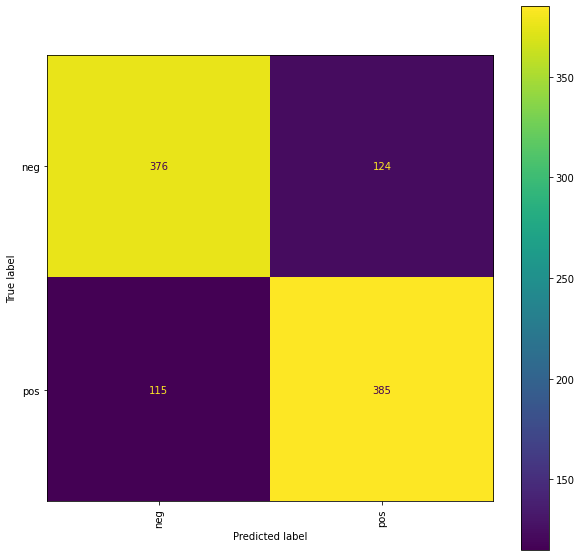

In [42]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most defining for each of the classes (ranked by how strong their corresponding coefficient is).  Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

**Answer: When looking at the most defining features for the positive class, we find many positive words such as top, high, very, excellent, definitely, etc. However, there are also words like us, thought, man, takes, gives, let that are very much neutral and common in reviews. The set of features for positive class in general tend to be positive on their own, and some of them if combined with other words can express very different sentiments (e.g. definitely waste of time) or simply describe the time when the reviewer watched the movie (e.g. late night).**

**On the other hand, we find some negative sentiment words (e.g. worst, waste, poor, stupid, least) on top of the list. We also find somewhat positive words like funny in the list; it possibly conveys the negation of funny with combination of other words (e.g. nothing funny, far from funny). Also, there are many neutral words (e.g. acting, actors, script) in the absence of context; they have more defining power than they should have, which limits the ability to generalize to unseen datasets. It can be helpful to include more n-gram features, like "not funny", "worth watching/not worth watching" to help flip the labels for those mistaken ones.**

In [43]:
big_classifier.printWeights(n=25)

pos	0.750	top
pos	0.531	high
pos	0.528	late
pos	0.524	away
pos	0.516	very
pos	0.515	different
pos	0.501	new
pos	0.439	excellent
pos	0.424	performance
pos	0.419	us
pos	0.408	definitely
pos	0.399	dead
pos	0.397	back
pos	0.392	thought
pos	0.390	saw
pos	0.389	down
pos	0.384	mind
pos	0.375	man
pos	0.374	comedy
pos	0.370	takes
pos	0.355	him
pos	0.355	want
pos	0.346	gives
pos	0.341	let
pos	0.331	'

neg	-0.925	worst
neg	-0.838	acting
neg	-0.762	?
neg	-0.694	funny
neg	-0.694	waste
neg	-0.652	poor
neg	-0.642	watching
neg	-0.605	least
neg	-0.600	actors
neg	-0.541	awful
neg	-0.534	far
neg	-0.531	boring
neg	-0.530	script
neg	-0.528	performances
neg	-0.491	would
neg	-0.486	instead
neg	-0.465	me
neg	-0.463	money
neg	-0.456	stupid
neg	-0.450	supposed
neg	-0.445	seems
neg	-0.444	idea
neg	-0.441	play
neg	-0.440	women
neg	-0.430	nothing



3. Next, let's look at the individual data points that are most mistaken. Does it suggest any features you might create to disentangle them?

**Answer: Among the top 20 most mistanken data points, 13 of them have ground true label of negative. After reading these most mistkened reviews, I find that these reviews are too nice (or implicit) in the way of expressing negative sentiments. Our model is not good at identifying these implicit meaning when a majority of features are looking at word-level. To disentangle them, I think it could be useful to include some common words (such as but, not) that are used in these implicit negative reviews. Further, I will try to add more features at the phrase level (n-gram). I will also take another look at the bag of words and see if there's way to reduce the dimensions that dominate the defining power over the relatively smaller number of n-gram features.**

In [44]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [45]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1551,0.999936,neg,pos,"I firmly believe that the best Oscar ceremony in recent years was in 2003 for two reasons: 1 ) Host Steve Martin was at his most wittiest: "" I saw the teamsters help Michael Moore into the trunk of his limo "" and "" I'll better not mention the gay mafia in case I wake up with a poodle's head in my bed "" 2 ) Surprise winners: No one had Adrien Brody down for best actor ( Genuine applause ) or Ro..."
1,1004,0.999120,neg,pos,"Certainly NOMAD has some of the best horse riding scenes, swordplay, and scrumptious landscape cinematography you'll likely see, but this isn't what makes a film good. It helps but the story has to shine through on top of these things. And that's where Nomad wanders.The story is stilted, giving it a sense that it was thrown together simply to make a ""cool"" movie that ""looks"" great. Not to ment..."
2,1436,0.997562,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
3,1659,0.990810,pos,neg,"Child 'Sexploitation' is one of the most serious issues facing our world today and I feared that any film on the topic would jump straight to scenes of an explicitly sexual nature in order to shock and disturb the audience. After having seen both 'Trade' and 'Holly', one film moved me to want to actually see a change in international laws. The other felt like a poor attempt at making me cry fo..."
4,1913,0.986488,neg,pos,"I have only seen Gretchen Mol in two other films (Girl 6, Donnie Brasco), and don't really remember her, but she did a great job as a naive girl who posed for pictures because it made people happy.She really didn't think what she was doing was wrong, even when she left the business and found her religion again.The photos she made were certainly tame by today's standards, and it is funny seeing..."
5,1929,0.981014,neg,pos,"At the name of Pinter, every knee shall bow - especially after his Nobel Literature Prize acceptance speech which did little more than regurgitate canned, by-the-numbers, sixth-form anti-Americanism. But this is even worse; not only is it a tour-de-force of talentlessness, a superb example of how to get away with coasting on your decades-old reputation, but it also represents the butchery of a..."
6,1309,0.978589,neg,pos,"Scooby Doo is undoubtedly one of the most simple, successful and beloved cartoon characters in the world. So, what happens when you've been everywhere and done everything with the formula? You switch it up right? Wrong. You stop production and let it rest for a decade or so and then run it again, keeping the core of its success intact. That is to say, stick with the formula for the most part b..."
7,1784,0.978583,pos,neg,"The only complaint I have about this adaptation is that it is sexed-up. Things that were only hinted at in the novel are shown on-screen for some weird reason. Did they think the audience would be too stupid to understand if they were not shown everything out-right? Other than that, this is very good-quality. All the actors do marvelous jobs bringing their characters to life. For the shallow w..."
8,1206,0.972073,neg,pos,"Plot Synopsis: Hong Kong, 1966. Paul Wagner, the man who built the Victoria Tunnel, is murdered along with his wife by his associates. His twin sons, Chad & Alex, are split apart. 25 years later, Chad, a karate instructor in Los Angeles, & Alex, a smuggler living in Hong Kong, join forces to avenge their parents' murder & rightfully claim the tunnel.This is the second time that Jean-Claude Van..."
9,1464,0.971872,neg,pos,"I really wanted to like this film, but so much of it is stolen/borrowed f